In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from google.cloud import bigquery
import datetime
import copy

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Data Retrieval

In [3]:
REFRESH=False

In [4]:
if REFRESH:
    
    sql = '''
        DECLARE latest_date DATE;
        SET latest_date = (
            SELECT MAX(offer_start_date) 
            FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` fcs
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code
                FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
            )
        );

        CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_EXEC_DEV` AS

        WITH dates_campaign AS (
            SELECT * 
            FROM (
                SELECT DISTINCT fw_start_date
                FROM `wx-bq-poc.loyalty.dim_date`
                WHERE fw_start_date >= '2020-08-31'
                    AND fw_start_date <= latest_date
            )
                CROSS JOIN (
                    SELECT DISTINCT 
                        campaign_code, 
                        CASE WHEN campaign_type = 'MP' AND campaign_length = 7 THEN 'MP1'
                                WHEN campaign_type = 'MP' AND campaign_length = 21 THEN 'MP3'
                                WHEN campaign_type = 'SS' AND campaign_length = 7 THEN 'SS1'
                                WHEN campaign_type = 'SS' AND campaign_length = 14 THEN 'SS2'
                                ELSE campaign_type 
                        END AS offer_type,
                    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
                )
            GROUP BY 1, 2, 3
        ),

        master_audience AS (
            SELECT
                campaign_start_date,
                campaign_code,
                COUNT(DISTINCT crn) AS audience
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales`
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code 
                FROM`gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
            )
            GROUP BY 1, 2
        ),

        promo AS (
            SELECT 
                fcs.campaign_start_date,
                fcs.offer_start_date,
                fcs.campaign_week_nbr,
                a.campaign_code,
                a.audience,
                0 AS post_week_flag,
                COUNT(DISTINCT fcs.redeem_flag) AS redeemers,
                SUM(fcs.attributed_inc_sales) AS inc_sales,
                SUM(fcs.reward_val) AS reward_val
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` fcs
                JOIN master_audience a 
                    ON fcs.campaign_start_date = DATE(a.campaign_start_date)
                    AND fcs.campaign_code = a.campaign_code
            GROUP BY 1, 2, 3, 4, 5
        ), 

        post AS (
            SELECT  
                ca.campaign_start_date,
                ca.fw_start_date,
                DATE_DIFF(ca.fw_start_date, ca.campaign_start_date, DAY) / 7 + 1 AS campaign_week_nbr,
                ca.campaign_code,
                a.audience,
                1 AS post_week_flag,
                0 AS redeemers,
                SUM(ca.inc_sales) AS inc_sales,
                0 AS reward_val
            FROM 
                `wx-bq-poc.loyalty_bi_analytics.cp_att_crn_halo_post_all` ca
                JOIN master_audience a 
                    ON ca.campaign_start_date = DATE(a.campaign_start_date)
                    AND ca.campaign_code = a.campaign_code
            GROUP BY 1, 2, 3, 4, 5
        ),

        promo_post AS (
            SELECT * FROM promo 
            UNION ALL
            SELECT * FROM post
        )

        SELECT
            dc.offer_type,
            dc.fw_start_date AS ds,
            campaign_week_nbr,
            SUM(audience) AS audience,
            SUM(redeemers) AS redeemers,
            SUM(inc_sales) AS inc_sales,
            SUM(reward_val) AS cost
        FROM 
            dates_campaign dc
            LEFT JOIN promo_post pp
                ON dc.fw_start_date = pp.offer_start_date
                AND dc.campaign_code = pp.campaign_code
        GROUP BY 1, 2, 3
        ORDER BY 1, 2, 3;

    '''

    response = bq.query(sql).result()

In [5]:
sql = '''
    SELECT *
    FROM `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_EXEC_DEV`
'''

data = bq.query(sql).result().to_dataframe()

data['inc_sales'] = data['inc_sales'].astype(float)
data['redeemers'] = data['redeemers'].astype(float)
data['cost'] = data['cost'].astype(float)
data['audience'] = data['audience'].astype(float)

data['rpc'] = data['inc_sales'] / data['audience']
data['rdm'] = data['redeemers'] / data['audience']
data['cpc'] = data['cost'] / data['audience']

In [6]:
WINDOW = 6
COEFF = 0.8

df = data.copy()
df = df[~df.offer_type.isin(['OSS', 'MP3'])]
train_df = df[df.ds < df.ds.unique()[-WINDOW]]
test_df = df[df.ds >= df.ds.unique()[-WINDOW]]

In [7]:
OFFER_TYPES = list(train_df['offer_type'].unique())
TEST_DATES = [ train_df.ds.max() + datetime.timedelta(days=7*i) for i in range(1,WINDOW+1) ]

LAST_EXEC_DATE = train_df[train_df.campaign_week_nbr == 1].ds.max()
LAST_DATE = train_df.ds.max()

In [8]:
df_audience = train_df[train_df['campaign_week_nbr'] == 1].groupby('ds').aggregate({'audience':'sum'}).reset_index()
for offer in OFFER_TYPES:
    df_audience_offer = train_df[(train_df['campaign_week_nbr'] == 1) & (train_df['offer_type'] == offer)][['ds', 'audience']]
    df_audience = df_audience.merge(df_audience_offer, how='left', left_on='ds', right_on='ds')
    df_audience['audience_y'] = df_audience['audience_y'] / df_audience['audience_x']
    df_audience.rename(columns={'audience_x': 'audience', 'audience_y': f'audience_{offer}'}, inplace=True)
    
df_audience['w'] = [COEFF**i for i in range(len(df_audience))][::-1]

expected_total_audience = np.sum(df_audience['w'] * df_audience['audience']) / np.sum(df_audience['w'])
expected_audience = {offer: 0 for offer in OFFER_TYPES}
for offer in OFFER_TYPES:
    a = np.sum(df_audience['w'] * df_audience[f'audience_{offer}']) / np.sum(df_audience['w'] * df_audience[f'audience_{offer}'].apply(lambda x: 0 if np.isnan(x) else 1))
    expected_audience[offer] = a
    
for offer in OFFER_TYPES:
    expected_audience[offer] = expected_audience[offer] / np.sum(list(expected_audience.values()))

In [33]:
expected_audience

{'2C': 0.0695290405819885,
 '4C': 0.061844124944494316,
 'MP1': 0.2723156919640158,
 'RA': 0.1102886494173038,
 'SGU': 0.09619144519010742,
 'SS1': 0.157609157108485,
 'SS2': 0.1695123618697798,
 'TMP': 0.11000017721584872}

In [9]:
campaign_length = train_df.groupby(['offer_type']).aggregate({'campaign_week_nbr': 'max'}).dropna().to_dict()['campaign_week_nbr']
CAMPAIGN_INFO = { 
    offer: {
        'length': campaign_length[offer],
        'size': expected_audience[offer]
    }
    for offer in OFFER_TYPES
}


In [10]:
def get_weight(row):
    weight = (LAST_DATE-row['ds']).days / 7
    weight = np.floor(weight / CAMPAIGN_INFO[row['offer_type']]['length'])
    weight = COEFF ** weight
    
#     weight = 1.0
    return weight

train_df['w'] = train_df.apply(lambda x: get_weight(x), axis=1)

train_df['wrpc'] = train_df['rpc'] * train_df['w']
train_df['wrdm'] = train_df['rdm'] * train_df['w']
train_df['wcpc'] = train_df['cpc'] * train_df['w']

/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a c

In [11]:
def _get_weight(row):
    weight = (row['ds_y']-row['ds_x']).days / 14.0
    weight = COEFF ** weight
    return weight

_df = train_df.groupby(['offer_type', 'campaign_week_nbr']).aggregate({'ds':'max'}).reset_index()
_df = train_df.merge(_df, left_on=['offer_type', 'campaign_week_nbr'], right_on=['offer_type', 'campaign_week_nbr'])
_df['w'] = _df.apply(lambda row: _get_weight(row), axis = 1)

_df['wrpc'] = _df['rpc'] * _df['w']
_df['wrdm'] = _df['rdm'] * _df['w']
_df['wcpc'] = _df['cpc'] * _df['w']

df_offer = _df.groupby(['offer_type', 'campaign_week_nbr']).aggregate({'w':'sum', 'wrpc':'sum', 'wrdm':'sum', 'wcpc':'sum'}).reset_index()
df_offer['rpc'] = df_offer['wrpc'] / df_offer['w']
df_offer['rdm'] = df_offer['wrdm'] / df_offer['w']
df_offer['cpc'] = df_offer['wcpc'] / df_offer['w']

df_offer = df_offer[['offer_type','campaign_week_nbr', 'rpc', 'rdm', 'cpc']]

In [14]:
df_offer = train_df.groupby(['offer_type', 'campaign_week_nbr']).aggregate({'w':'sum', 'wrpc':'sum', 'wrdm':'sum', 'wcpc':'sum'}).reset_index()
df_offer['rpc'] = df_offer['wrpc'] / df_offer['w']
df_offer['rdm'] = df_offer['wrdm'] / df_offer['w']
df_offer['cpc'] = df_offer['wcpc'] / df_offer['w']

In [15]:
df_offer

offer_type  campaign_week_nbr         w       wrpc      wrdm      wcpc  \
0          2C                1.0  5.698798  10.121363  0.000000  0.000000   
1          2C                2.0  6.115127   7.147227  0.102147  3.066232   
2          2C                3.0  5.380378  -1.677485  0.000000  0.000000   
3          4C                1.0  6.920327  17.878611  0.000000  0.000000   
4          4C                2.0  7.227786  13.237010  0.000000  0.000000   
5          4C                3.0  6.414629  13.047008  0.000000  0.000000   
6          4C                4.0  6.700612  11.371979  0.107375  4.480052   
7          4C                5.0  5.834935  -2.472360  0.000000  0.000000   
8         MP1                1.0  4.886425   8.194987  0.695754  1.538985   
9         MP1                2.0  4.886425  -2.231834  0.000000  0.000000   
10         RA                1.0  7.249232   4.809126  0.105202  0.516131   
11         RA                2.0  7.249232   4.339480  0.102111  1.006564   
12         RA                3.0  7.046801   5.372596  0.114539  1.708798   
13         RA                4.0  7.046801  -0.376097  0.000000  0.000000   
14        SGU                1.0  6.917456  10.824354  0.115374  1.387194   
15        SGU                2.0  6.917456   7.922255  0.125911  1.523068   
16        SGU                3.0  6.566545   1.242196  0.030854  0.498587   
17        SGU                4.0  6.566545  -0.112840  0.000000  0.000000   
18        SS1                1.0  4.632753   9.966183  0.137107  1.832953   
19        SS1                2.0  4.632753  -0.892025  0.000000  0.000000   
20        SS2                1.0  5.753773  11.927327  0.198264  0.929888   
21        SS2                2.0  6.183846   8.015998  0.230177  1.083421   
22        SS2                3.0  5.449098  -2.643720  0.000000  0.000000   
23        TMP                1.0  2.440000   7.099200  0.255618  1.405730   
24        TMP                2.0  2.440000  -0.835193  0.000000  0.000000   

         rpc       rdm       cpc  
0   1.776052  0.000000  0.000000  
1   1.168778  0.016704  0.501418  
2  -0.311778  0.000000  0.000000  
3   2.583492  0.000000  0.000000  
4   1.831406  0.000000  0.000000  
5   2.033946  0.000000  0.000000  
6   1.697155  0.016025  0.668603  
7  -0.423717  0.000000  0.000000  
8   1.677093  0.142385  0.314951  
9  -0.456742  0.000000  0.000000  
10  0.663398  0.014512  0.071198  
11  0.598612  0.014086  0.138851  
12  0.762416  0.016254  0.242493  
13 -0.053371  0.000000  0.000000  
14  1.564788  0.016679  0.200535  
15  1.145255  0.018202  0.220177  
16  0.189170  0.004699  0.075928  
17 -0.017184  0.000000  0.000000  
18  2.151244  0.029595  0.395651  
19 -0.192548  0.000000  0.000000  
20  2.072957  0.034458  0.161614  
21  1.296280  0.037222  0.175202  
22 -0.485167  0.000000  0.000000  
23  2.909508  0.104762  0.576119  
24 -0.342292  0.000000  0.000000

In [16]:
# audience_df = train_df[train_df.campaign_week_nbr == 1][['offer_type', 'w', 'audience']]
# audience_df['waudience'] = audience_df['w'] * audience_df['audience']
# audience_df = audience_df.groupby('offer_type').aggregate({'w':'sum', 'waudience': 'sum'})
# audience_df['audience'] =  audience_df['waudience'] / audience_df['w']
# campaign_audience = audience_df.to_dict()['audience']

In [17]:
offer_exclusion = {
    datetime.date(2021, 9, 27): [],
    datetime.date(2021, 10, 4): [],
    datetime.date(2021, 10, 11): [],
    datetime.date(2021, 10, 18): [],
    datetime.date(2021, 10, 25): [],
    datetime.date(2021, 11, 1): [],
}

In [19]:
import copy

def simulate(df, next_date, offer_type, campaign_info):
        
    campaign_length = campaign_info[offer_type]['length']   
    campaign_size = campaign_info[offer_type]['size'] 

    last_exec_date = df[df.campaign_week_nbr == 1].ds.max()
    last_date = df.ds.max()

    response = df[df['offer_type'] == offer_type][['offer_type', 'ds', 'campaign_week_nbr', 'audience']]
    response = response[response['ds'] == last_date]
    response['ds'] = next_date
    response['campaign_week_nbr'] += 1
    response = response[response['campaign_week_nbr'] <= campaign_length]

    if last_exec_date == last_date:
        response.reset_index(drop=True, inplace=True)
    else:
        response=response.append(
            pd.DataFrame({
                'offer_type': [offer_type],
                'ds': [next_date],
                'campaign_week_nbr': [1.0],
                'audience': [campaign_size],
            }), ignore_index=True
        )            

    return response
      
results = []
for offer_type in OFFER_TYPES:
    
    response = train_df.copy()
    for test_date in TEST_DATES:
    
        # scaling audience size if there are exclusions
        current_campaign_info = copy.deepcopy(CAMPAIGN_INFO)
        
        total_size = 0
        for offer in OFFER_TYPES:
            if offer in offer_exclusion[test_date]:
                current_campaign_info[offer]['size'] = 0
            total_size += current_campaign_info[offer]['size']

        for offer in OFFER_TYPES:     
            current_campaign_info[offer]['size'] = current_campaign_info[offer]['size'] / total_size * expected_total_audience
    
        response = simulate(response, test_date, offer_type, current_campaign_info)
        results.append(response)

results = pd.concat(results, ignore_index=True)

In [20]:
forecast = results.merge(df_offer, left_on=['offer_type','campaign_week_nbr'], right_on=['offer_type','campaign_week_nbr'])
forecast = forecast.sort_values(by=['offer_type', 'ds', 'campaign_week_nbr'])

forecast['inc_sales'] = forecast['rpc'] * forecast['audience']
forecast['cost'] = forecast['cpc'] * forecast['audience']
forecast['redeemers'] = forecast['rdm'] * forecast['audience']

In [21]:
def get_weekly(df):
    df = df.groupby(['offer_type', 'ds']).aggregate({'audience': 'sum', 'inc_sales': 'sum', 'cost': 'sum', 'redeemers':'sum'}).reset_index()
    df['rpc'] = df['inc_sales'] / df['audience']
    df['rdm'] = df['redeemers'] / df['audience']
    
    return df

weekly_forecast = get_weekly(forecast)
weekly_history = get_weekly(train_df)
weekly_holdout = get_weekly(test_df)

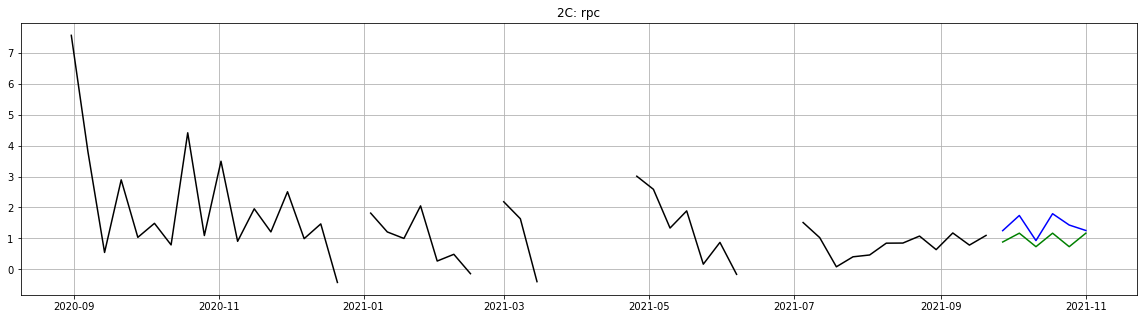

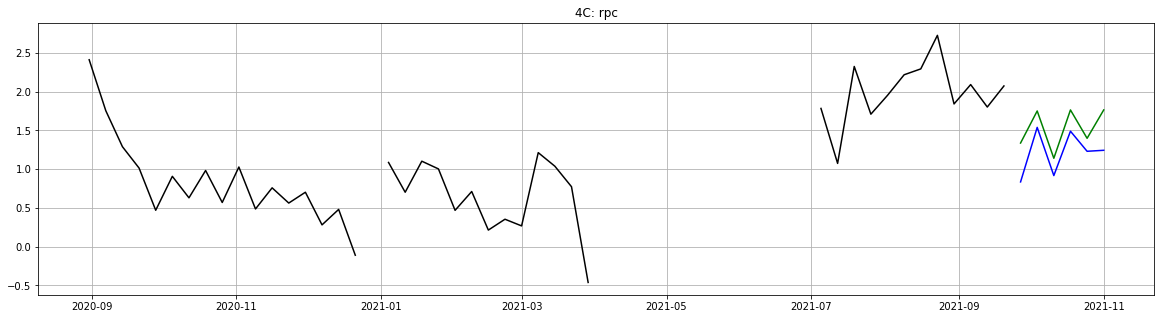

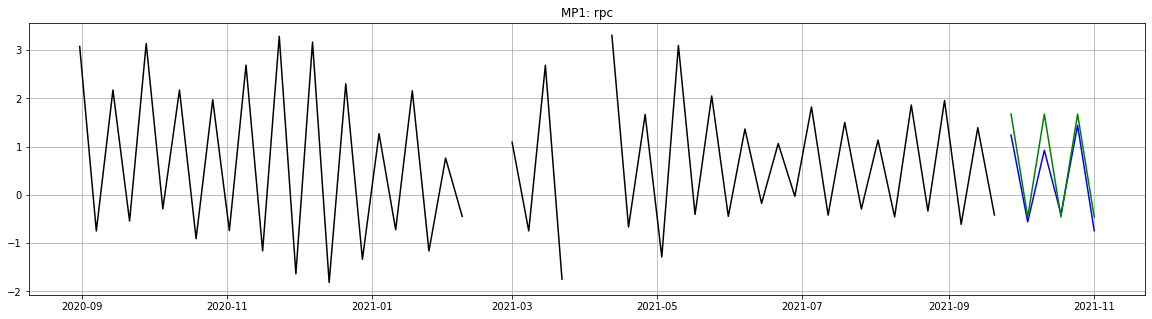

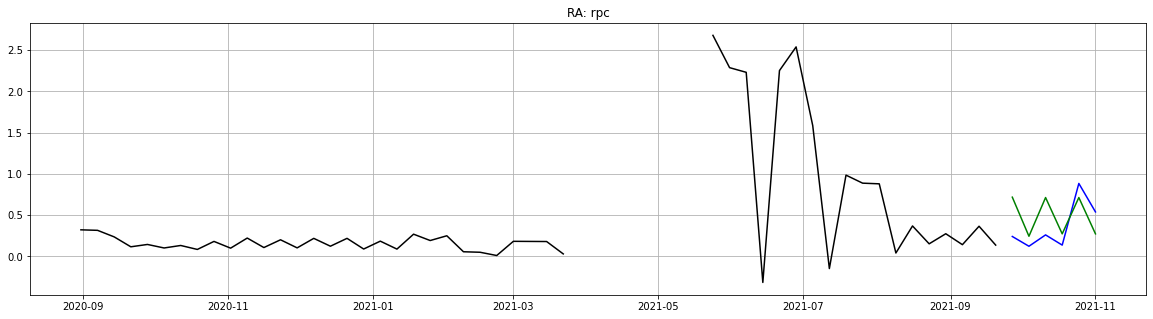

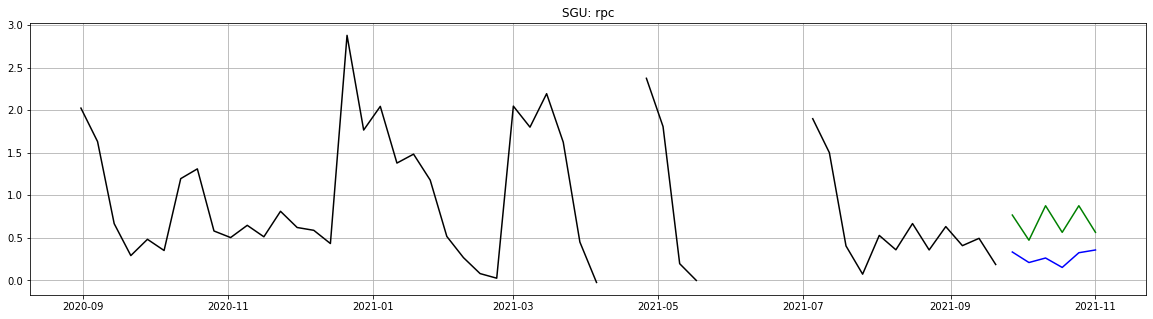

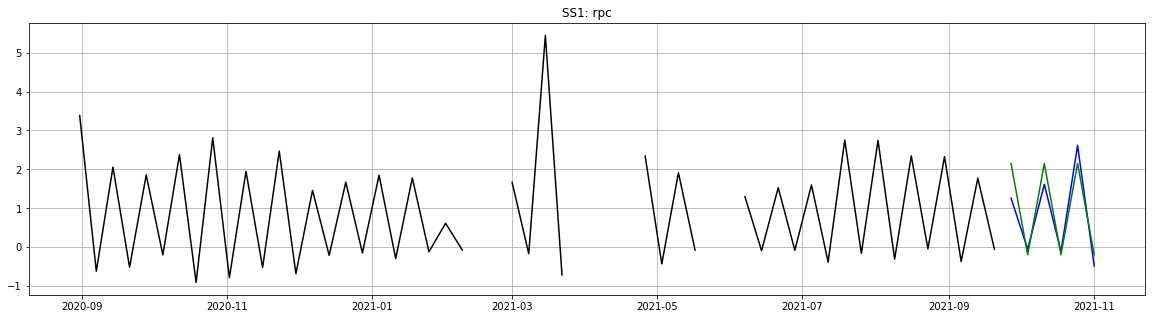

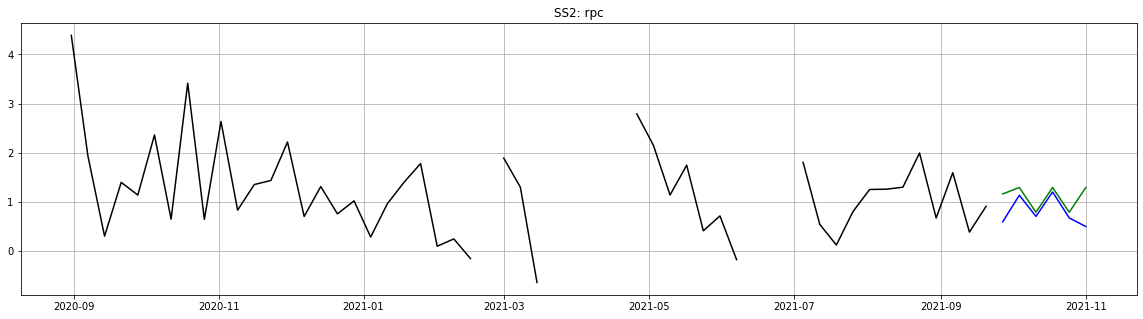

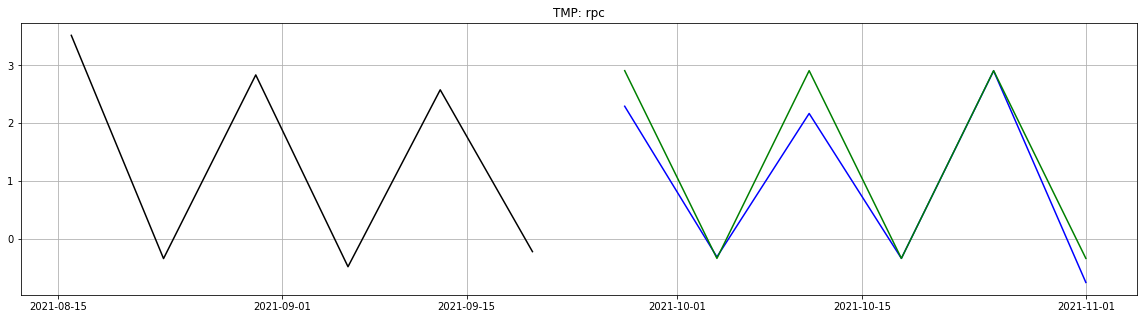

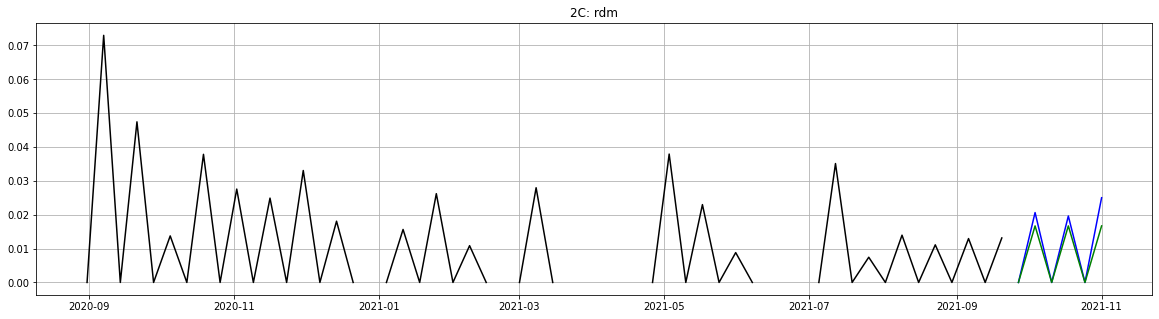

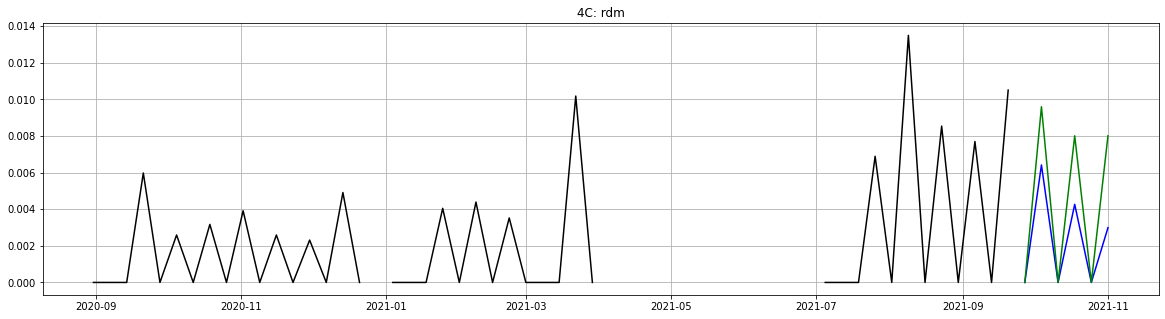

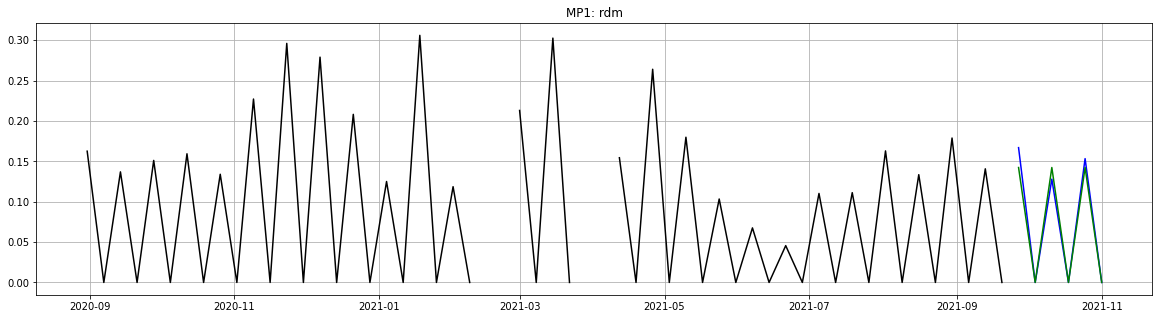

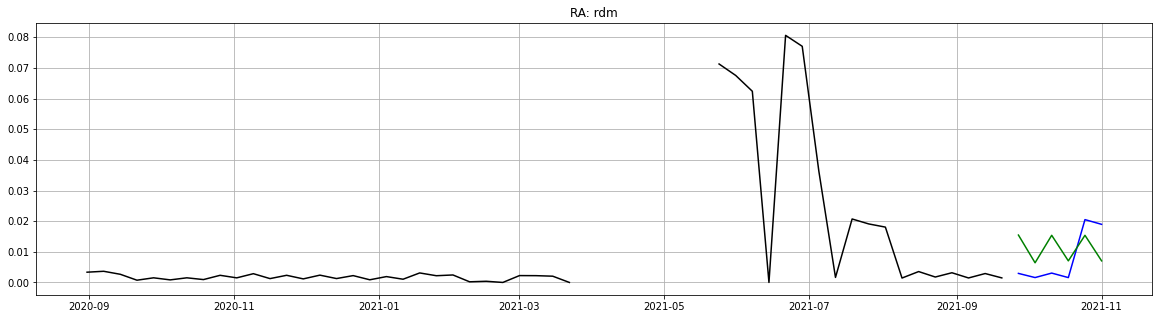

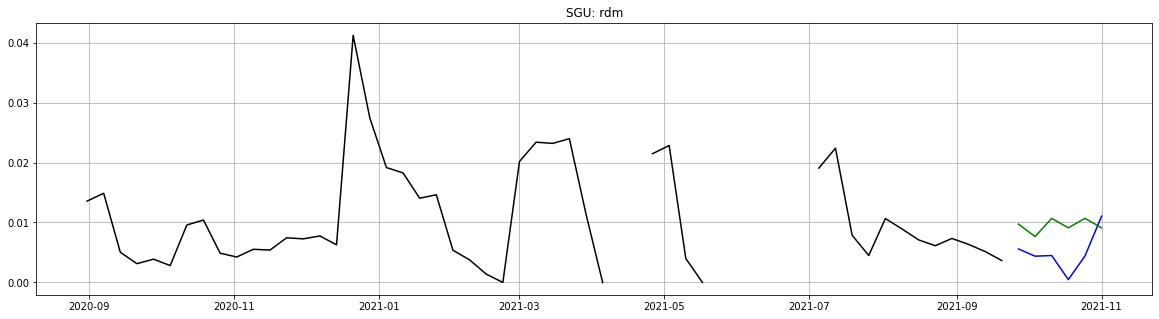

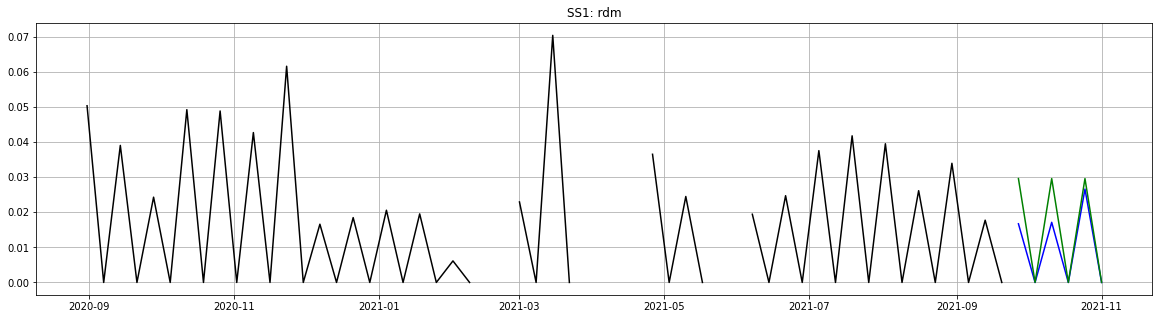

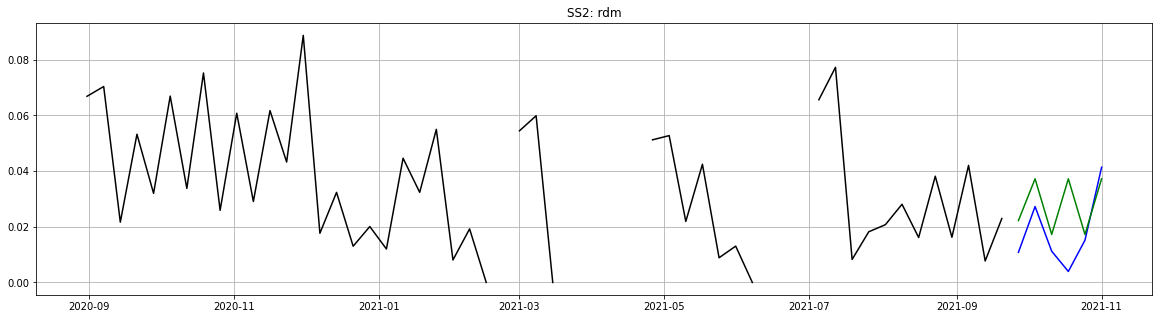

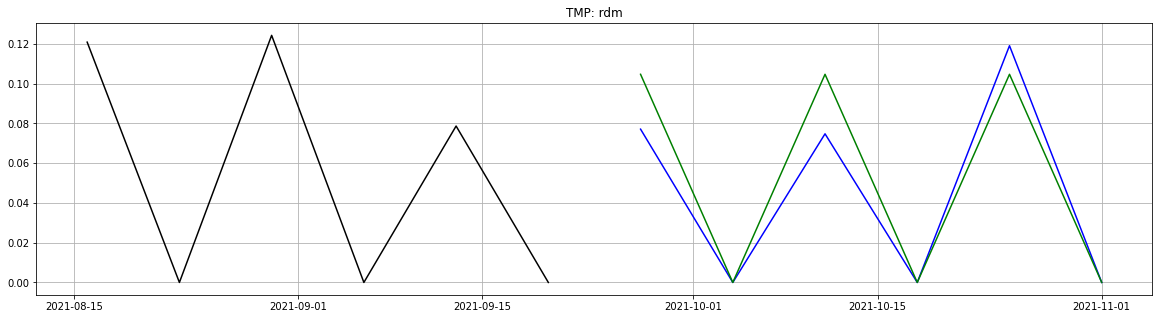

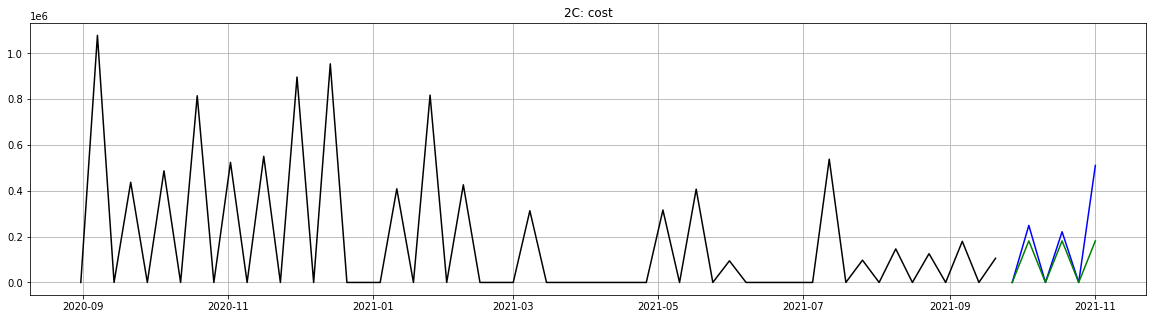

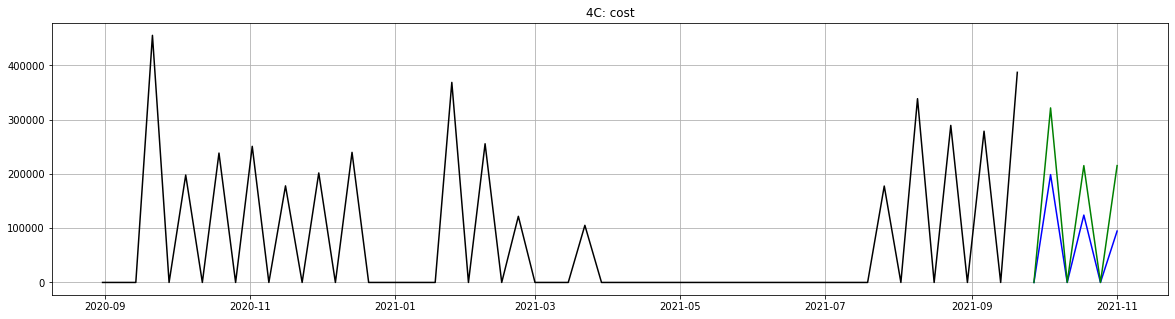

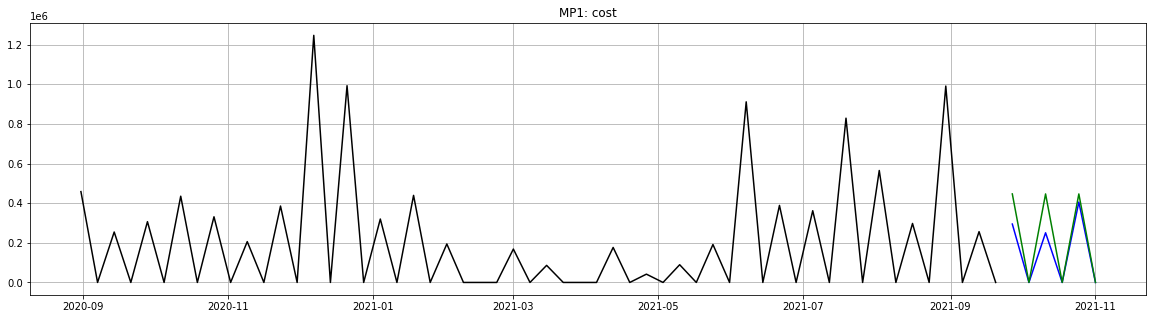

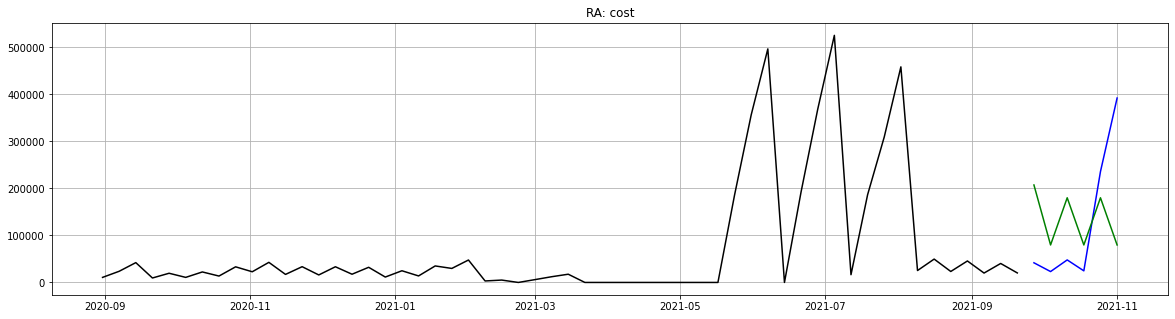

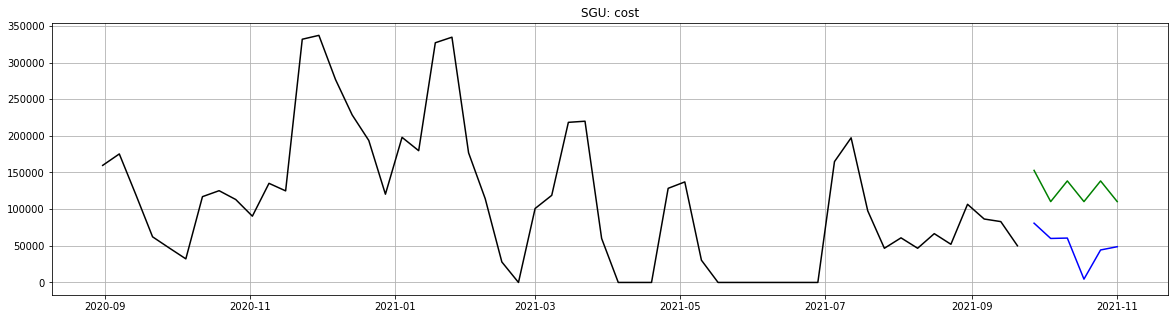

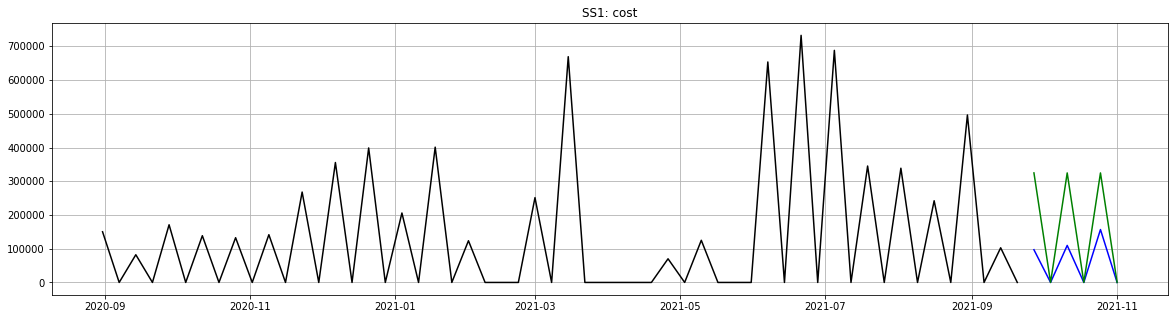

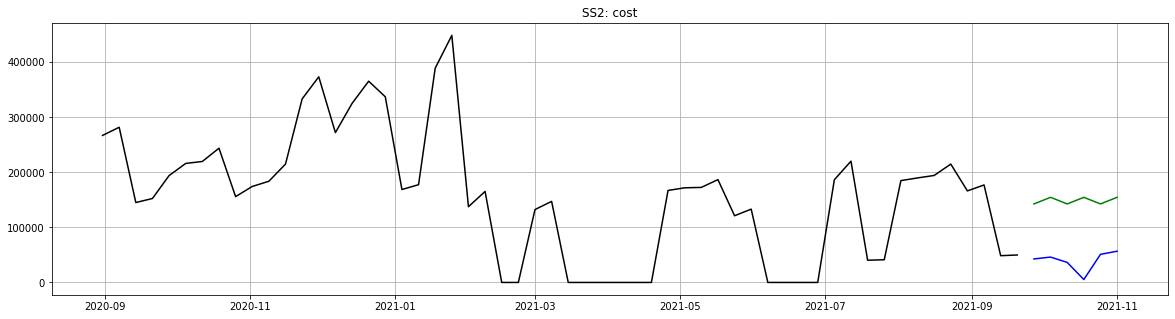

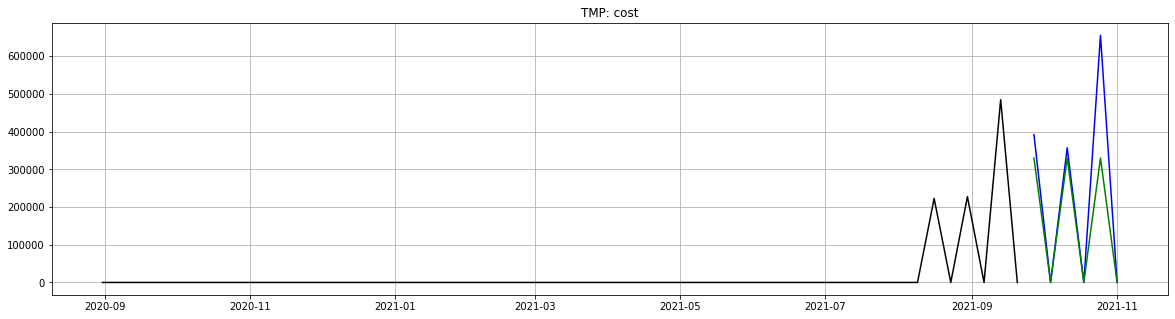

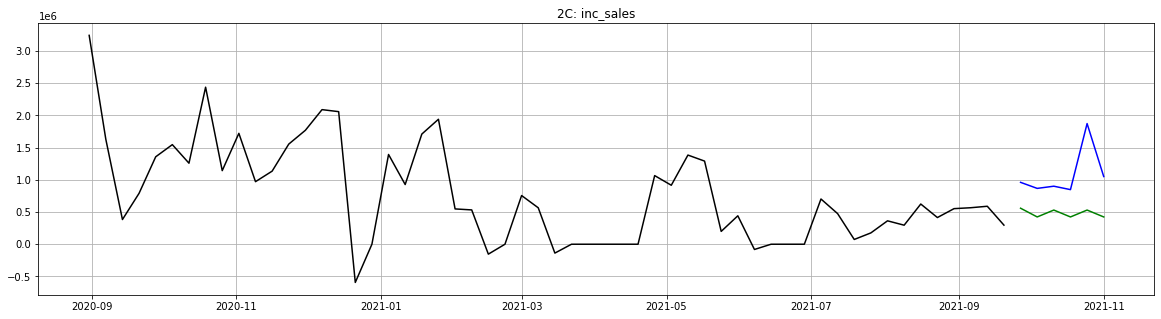

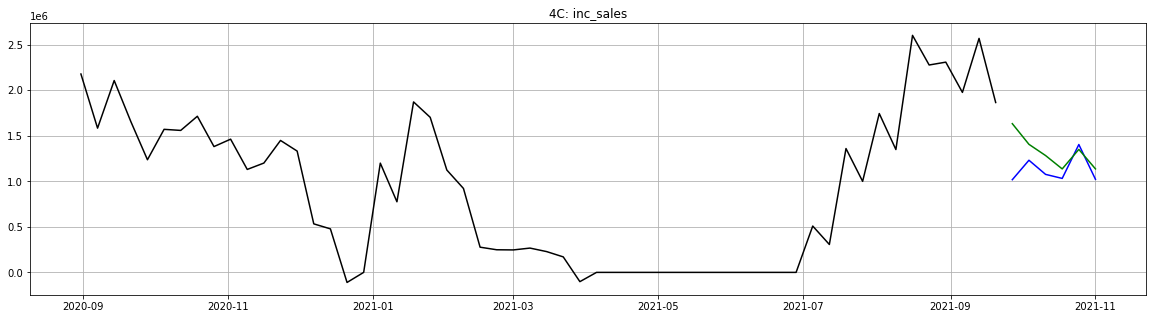

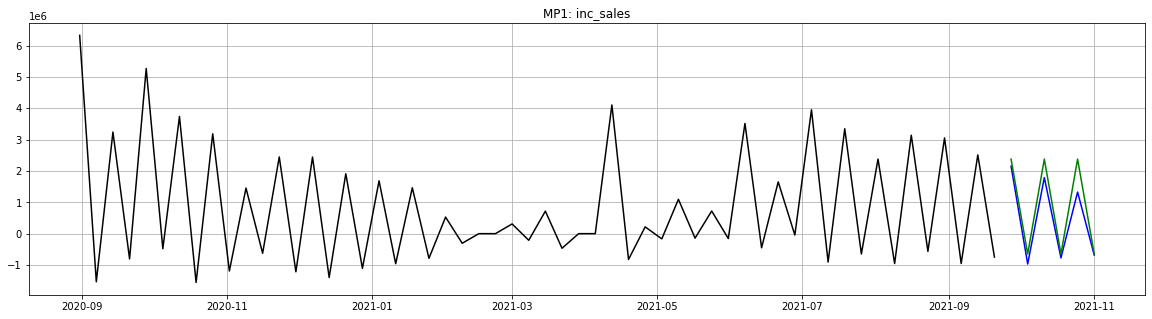

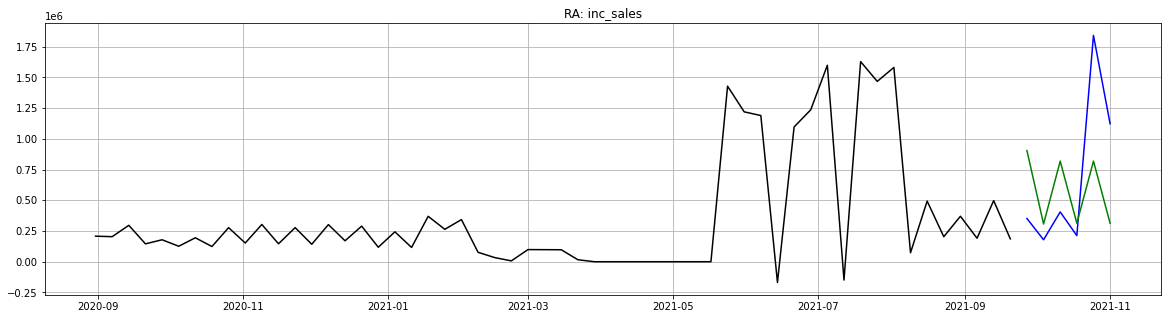

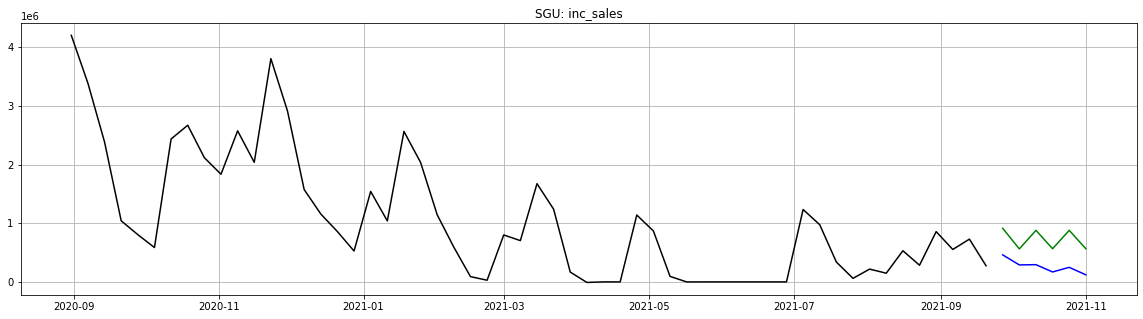

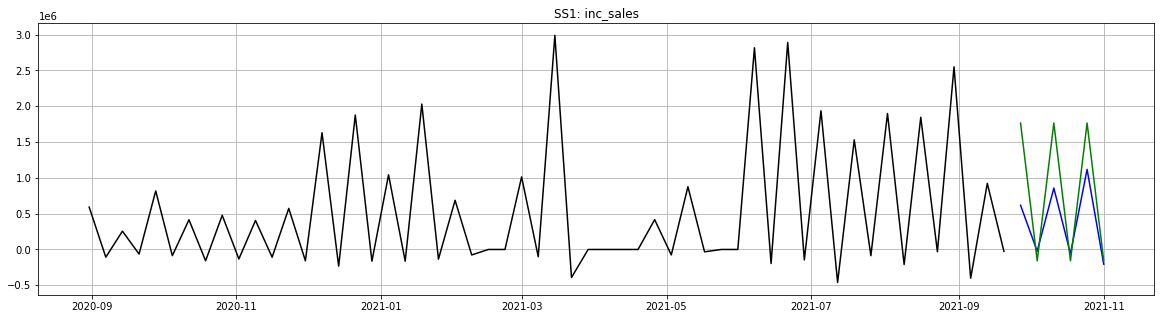

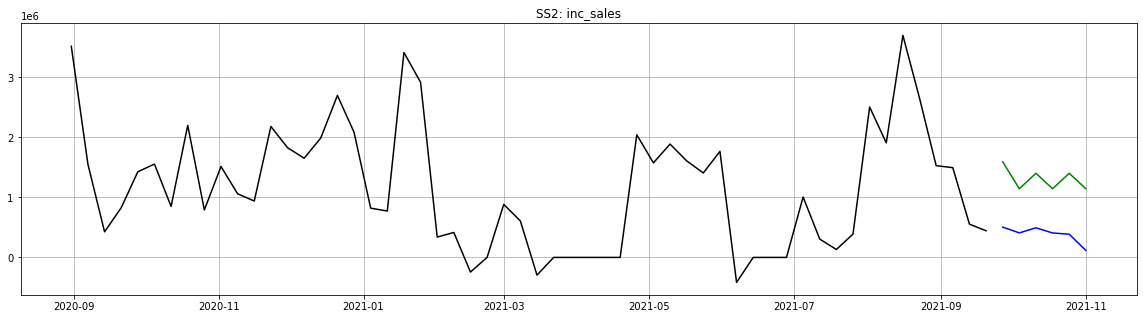

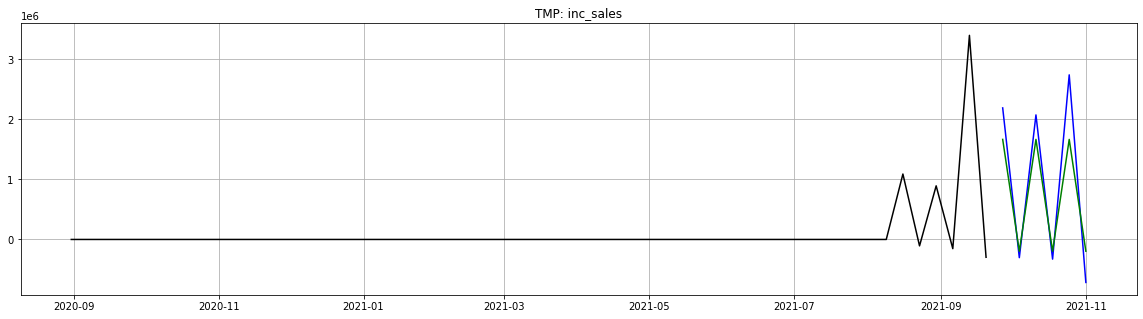

In [22]:
for metric in ['rpc', 'rdm', 'cost', 'inc_sales']:
    for offer_type in OFFER_TYPES:

        campaign_weekly_history = weekly_history[weekly_history.offer_type == offer_type]
        campaign_weekly_forecast = weekly_forecast[weekly_forecast.offer_type == offer_type]
        campaign_weekly_holdout = weekly_holdout[weekly_holdout.offer_type == offer_type]
        
        plt.figure(figsize=(20,5))
        plt.title(f'{offer_type}: {metric}')
        plt.plot(campaign_weekly_history.ds, campaign_weekly_history[metric], color='k')
        plt.plot(campaign_weekly_holdout.ds, campaign_weekly_holdout[metric], color='b')
        plt.plot(campaign_weekly_forecast.ds, campaign_weekly_forecast[metric], color='g')
        plt.grid()
        plt.show()

### Overall prediction

In [23]:
def get_weekly_all(df):
    df = df.groupby(['ds']).aggregate({'audience': 'sum', 'inc_sales': 'sum', 'cost': 'sum', 'redeemers':'sum'}).reset_index()
    df['rpc'] = df['inc_sales'] / df['audience']
    df['rdm'] = df['redeemers'] / df['audience']
    
    return df


weekly_forecast_all = get_weekly_all(forecast)
weekly_history_all = get_weekly_all(train_df)
weekly_holdout_all = get_weekly_all(test_df)

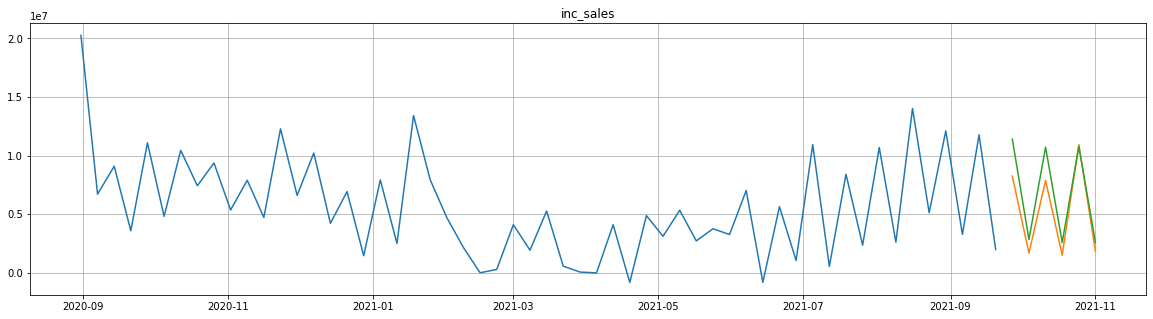

sMAPE = 16.83625576214144


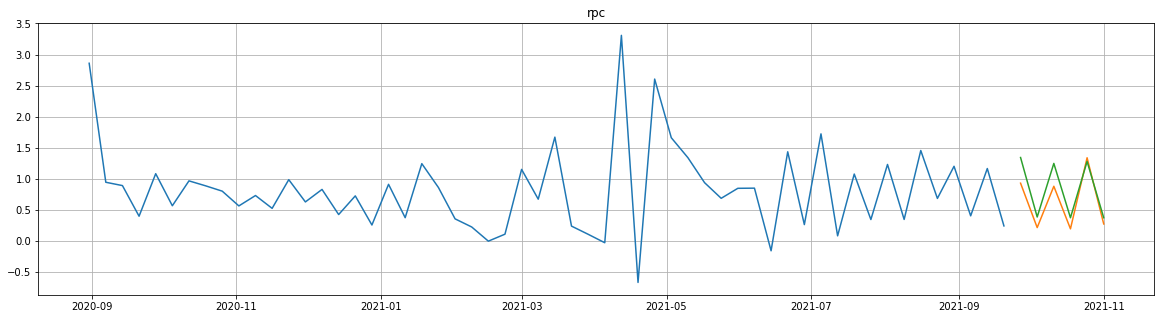

sMAPE = 18.650204508426036


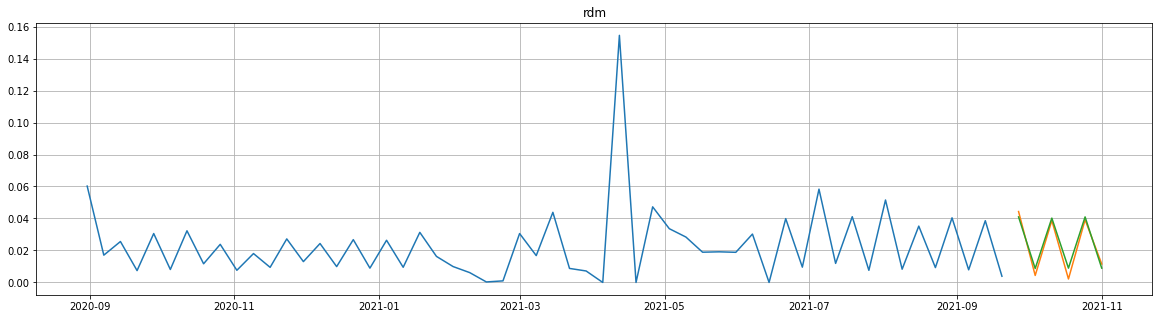

sMAPE = 19.16166263160891


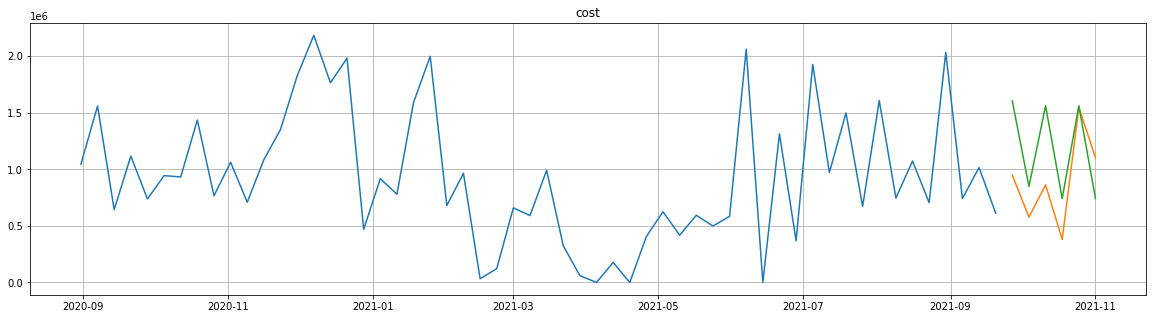

sMAPE = 20.969608946242722


In [24]:
def eval_smape(y, yhat):
    return np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

metrics = ['inc_sales', 'rpc', 'rdm', 'cost']

for metric in metrics:
    
    plt.figure(figsize=(20,5))
    plt.title(f'{metric}')
    plt.plot(weekly_history_all.ds, weekly_history_all[metric])
    plt.plot(weekly_holdout_all.ds, weekly_holdout_all[metric])
    plt.plot(weekly_forecast_all.ds, weekly_forecast_all[metric])
    plt.grid()
    plt.show()
    
    print(f'sMAPE = {eval_smape(weekly_holdout_all[metric], weekly_forecast_all[metric])}')

### Monthly

In [25]:
sql = '''
    SELECT * 
    FROM (
        SELECT DISTINCT 
            fp_start_date AS dt, 
            fw_start_date AS ds
        FROM `wx-bq-poc.loyalty.dim_date`
        WHERE fp_start_date >= '2020-08-31'
            AND DATE(fp_end_date) < current_date('Australia/ACT')
    )
'''

monthly = bq.query(sql).result().to_dataframe()

In [26]:
def get_monthly(df):
    month_agg_data = monthly.merge(df, left_on='ds', right_on='ds').sort_values(by='dt')
    month_agg_data = month_agg_data.groupby('dt').aggregate({
        'audience': 'sum',
        'inc_sales': 'sum',
        'cost': 'sum',
        'redeemers': 'sum',
    }).reset_index()

    month_agg_data['rpc'] = month_agg_data['inc_sales'] / month_agg_data['audience']
    month_agg_data['rdm'] = month_agg_data['redeemers'] / month_agg_data['audience']
    
    return month_agg_data

monthly_forecast = get_monthly(weekly_forecast_all)

In [27]:
weekly_data = get_weekly_all(data)
monthly_data = get_monthly(data)

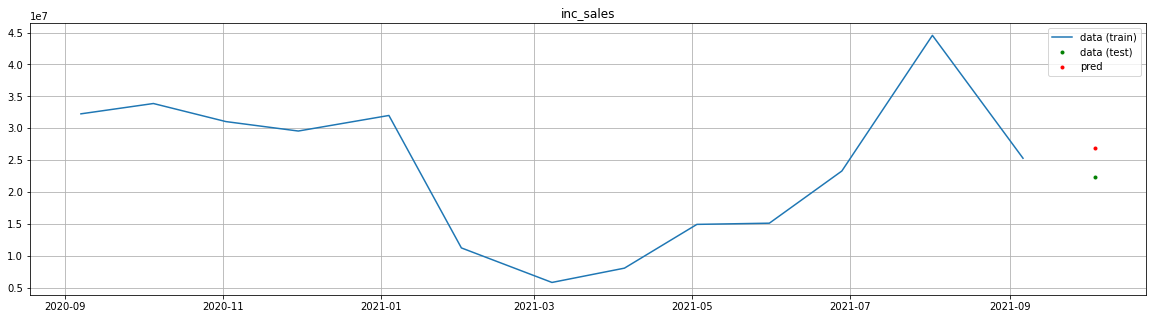

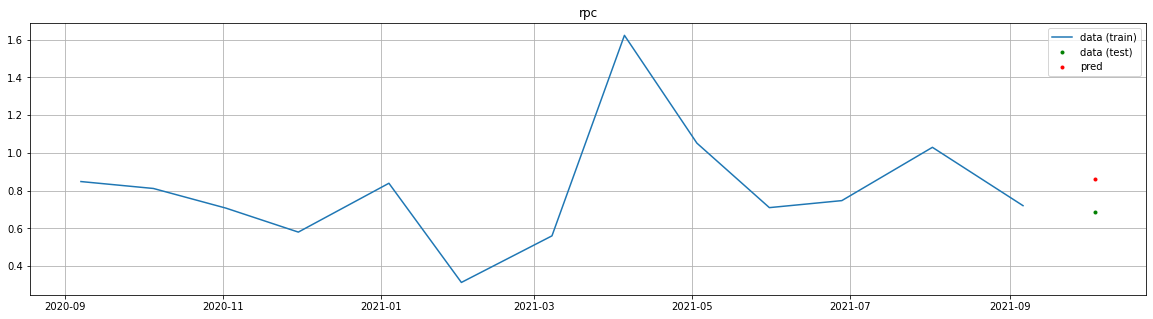

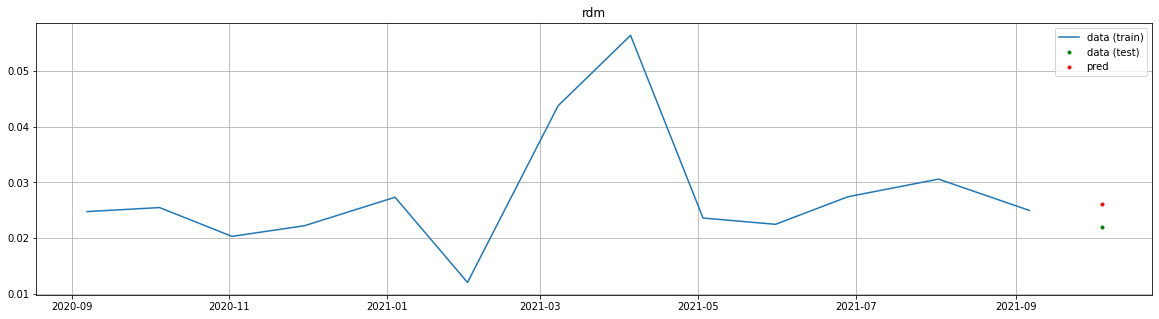

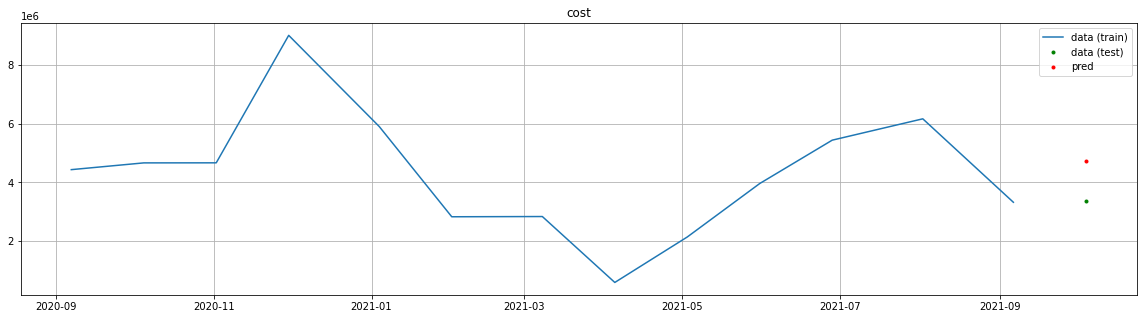

In [28]:
metrics = ['inc_sales', 'rpc', 'rdm', 'cost']

for metric in metrics: 
    
    ds = monthly_data['dt']
    y = monthly_data[metric]
    yhat = monthly_forecast[metric]

    plt.figure(figsize=(20,5))
    plt.title(metric)
    plt.plot(ds[:-1], y[:-1], label='data (train)')
    plt.plot(ds[-1:], y[-1:], 'g.', label='data (test)')
    plt.plot(ds[-1:], yhat[-1:], 'r.', label=f'pred')
    plt.legend()
    plt.grid()
    plt.show()

### Marketing comparison

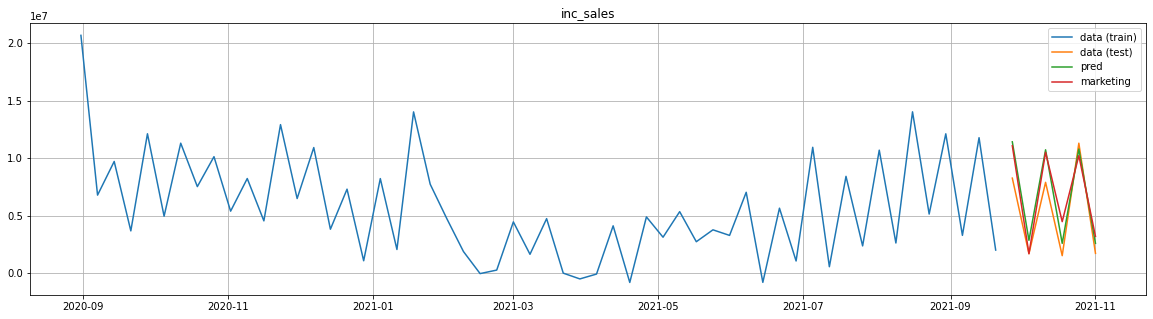

sMAPE (marketing) : 18.92058745257056
sMAPE (ours)      : 17.634051536715354


In [29]:
metric = 'inc_sales'
marketing_forecast = [11073884, 1677227, 10501327, 4468763, 10213124, 3186009]

ds = weekly_data['ds']
y = weekly_data[metric]
yhat = weekly_forecast_all[metric]

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat, label=f'pred')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'marketing')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(np.array(marketing_forecast), np.array(y[-WINDOW:]))}')
print(f'sMAPE (ours)      : {eval_smape(np.array(yhat), np.array(y[-WINDOW:]))}')

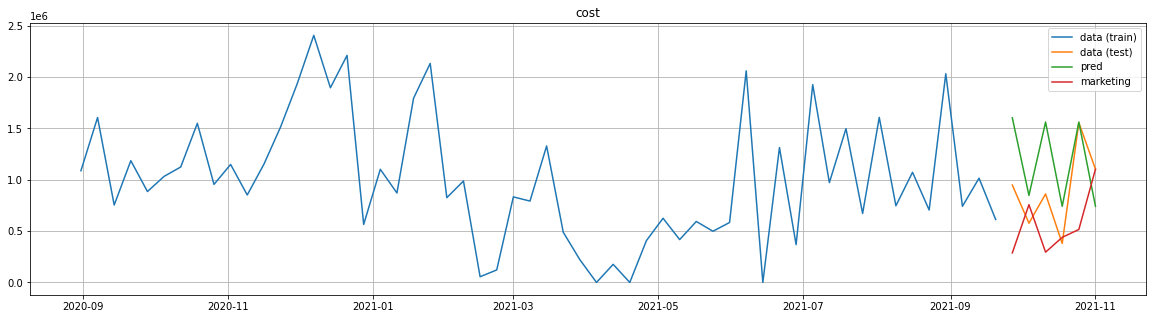

sMAPE (marketing) : 28.90678521057351
sMAPE (ours)      : 20.925662394884796


In [30]:
metric = 'cost'
marketing_forecast = [287873, 757451, 295084, 439295, 515855, 1103087]

ds = weekly_data['ds']
y = weekly_data[metric]
yhat = weekly_forecast_all[metric]

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat, label=f'pred')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'marketing')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(np.array(marketing_forecast), np.array(y[-WINDOW:]))}')
print(f'sMAPE (ours)      : {eval_smape(np.array(yhat), np.array(y[-WINDOW:]))}')